# IOOS Access 02: Accessing model output via the IOOS Catalog OGC CSW endpoint
[Emilio Mayorga](https://github.com/emiliom), University of Washington & [NANOOS](http://www.nanoos.org/). 2018-8-21.

See IOOS Access Notebook 1 for background and discussion on the IOOS Catalog, its OGC CSW web service endpoint, service types, etc. This notebook follows a similar logic and sequence, but focuses instead on model forecast results rather than observations. And on the **OOI Pioneer Array** rather than the Endurance Array.

Adapted from Filipe Fernandes' (@ocefpaf) notebook, http://nbviewer.jupyter.org/gist/ocefpaf/36ab048b94859e8bf9a070db95fed174

## Preamble

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import folium

## 1. Define the Pioneer Array bounding box and convert to a GeoPandas GeoSeries
http://oceanobservatories.org/array/coastal-pioneer/

In [3]:
import shapely.geometry as shpgeom

min_lon, max_lon = -72, -69
min_lat, max_lat = 38.5, 41

pioneer_bbox_shp = shpgeom.box(min_lon, min_lat, max_lon, max_lat)
pioneer_bbox_gs = gpd.GeoSeries(pioneer_bbox_shp)

## 2. Create the catalog query filters and issue the OGC CSW query to the IOOS Catalog web service

In [4]:
from owslib import fes

In [5]:
bbox = [min_lon, min_lat, max_lon, max_lat]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

bbox_crs = fes.BBox(bbox, crs=crs)

In [6]:
from datetime import datetime, timedelta
from ioos_tools.ioos import fes_date_filter

dt = 20

date = datetime.utcnow()
start = date - timedelta(days=dt)
stop = date + timedelta(days=dt)

begin, end = fes_date_filter(start, stop)

In [7]:
cf_names = [
    'sea_water_temperature',
    'sea_surface_temperature',
    'sea_water_potential_temperature',
    'equivalent_potential_temperature',
    'sea_water_conservative_temperature',
    'pseudo_equivalent_potential_temperature',
]


kw = dict(
    wildCard='*',
    escapeChar='\\',
    singleChar='?',
    propertyname='apiso:AnyText'
)

or_filt = fes.Or(
    [fes.PropertyIsLike(literal=('*%s*' % val), **kw)
        for val in cf_names])

In [8]:
filter_list = [
    fes.And(
        [
            bbox_crs,
            begin, end,
            or_filt,
            fes.PropertyIsLike(literal=('*%s*' % 'forecast'), **kw),  # Rough mechanism to return model forecast results only
            fes.Not([fes.PropertyIsLike(literal='*cdip*', **kw)]),
            fes.Not([fes.PropertyIsLike(literal='*grib*', **kw)]),
        ]
    )
]

In [9]:
from owslib.csw import CatalogueServiceWeb
from ioos_tools.ioos import get_csw_records

endpoint = 'https://data.ioos.us/csw'

csw = CatalogueServiceWeb(endpoint, timeout=60)

get_csw_records(
    csw,
    filter_list,
    pagesize=10,
    maxrecords=1000
)

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))

Found 5 records.



Display a summary of all the records found.

In [10]:
for key, value in list(csw.records.items()):
    print(u'[{}]\n  {}'.format(value.title, key))

[COAWST Modeling System: USEast: ROMS-WRF-SWAN coupled model (aka CNAPS)]
  fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd
[Coupled Northwest Atlantic Prediction System (CNAPS)]
  edu.ncsu.meas:cnaps
[HYbrid Coordinate Ocean Model (HYCOM): Global]
  hycom_global
[ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC Averages]
  edu.rutgers.marine:roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best
[ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC History]
  edu.rutgers.marine:roms/espresso/2013_da/his/ESPRESSO_Real-Time_v2_History_Best


The scheme for selecting model forecasts yielded decent results! (But compare them to results w/o the 'forecast' filter)

## 3. Explore the results
Examine their web service types, and create spatial domain "grid" objects for mapping.

In [11]:
from geolinks import sniff_link


df = []

for key, rec in csw.records.items():
    df.append(pd.DataFrame(rec.references))

df = pd.concat(df, ignore_index=True)
df['geolink'] = [sniff_link(url) for url in df['url']]

As in Notebook 1, let's compare the web-service-type results from`geolink.sniff_link` and reference `scheme`, this time for the `OPeNDAP` service type that model forecasts are distributed in. Unfortunately, the match up is not good, so we'll need to make some selections (in the next cell) to isolate appropriate service links, relying on the `scheme` links.

*Note: The accuracy of `geolink.sniff_link` could be improved by refinements to that community package, plus better implementation of web service labeling in the model forecast servers.*

In [12]:
df.loc[(df['scheme'] == 'OPeNDAP:OPeNDAP') | (df['geolink'] == 'OPeNDAP:OPeNDAP')]

,scheme,url,geolink
7,OPeNDAP:OPeNDAP,http://thredds.secoora.org/thredds/dodsC/SECOO...,None
17,OPeNDAP:OPeNDAP,http://oos.soest.hawaii.edu/thredds/dodsC/paci...,None
23,OPeNDAP:OPeNDAP,http://tds.marine.rutgers.edu/thredds/dodsC/ro...,None
28,OPeNDAP:OPeNDAP,http://tds.marine.rutgers.edu/thredds/dodsC/ro...,None


In [13]:
dap_urls = []

for i, df_row in df.iterrows():
    row = df_row.to_dict()
    # Handle the presenece of "opendap" in the NOAA NOS-COOPS obs domain
    url = row['url']
    if row['scheme'] == 'OPeNDAP:OPeNDAP' or 'dodsC' in url:
        if not '.html' in url:
            dap_urls.append(url)

In [14]:
len(dap_urls)

9

In [15]:
dap_urls

['http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd',
 'http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc',
 'http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc',
 'http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best',
 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/his/ESPRESSO_Real-Time_v2_History_Best',
 '

Not all these service end points may in fact be proper OPeNDAP end points. And some may not be working at this time. So, the block below will include additional tests.

We'll use the `gridgeo` package to create geographical gridded masks and outer polygons for the model domains, for the models that are proper, functioning OPeNDAP end points. These will be stored in the `grids` list.

In [16]:
from netCDF4 import Dataset
import gridgeo


grids = {}
for url in dap_urls:
    try:
        nc = Dataset(url)
    except:
        print(f'  - Could not read {url} as OPeNDAP endpoint.')
        continue

    temp = nc.get_variables_by_attributes(standard_name=lambda x: x in cf_names)[0]
    standard_name = temp.standard_name

    try:
        grid = gridgeo.GridGeo(nc, standard_name=standard_name)
        title = getattr(nc, 'title', url)
        print(f'{url}: {title}')
    except Exception:
        print(f'  - Could not get grid for {url}')
        continue
    grids.update({title: grid})

  - Could not read http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd as OPeNDAP endpoint.
http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd: COAWST Modeling System: USEast: ROMS-WRF-SWAN coupled model (aka CNAPS)
  - Could not read http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc as OPeNDAP endpoint.
http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc: Coupled Northwest Atlantic Prediction System (CNAPS)
  - Could not read http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global as OPeNDAP endpoint.
  - Could not read http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best as OPeNDAP endpoint.
http://tds.marine.r

In [17]:
grids

{'COAWST Modeling System: USEast: ROMS-WRF-SWAN coupled model (aka CNAPS)': <GridGeo: unknown_2d>,
 'Coupled Northwest Atlantic Prediction System (CNAPS)': <GridGeo: unknown_2d>,
 'ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC Averages': <GridGeo: sgrid>,
 'ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC History': <GridGeo: sgrid>}

## 4. Map the model domains in a Folium map, together with the Pioneer Array bounding box

In [18]:
tiles = 'http://services.arcgisonline.com/arcgis/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}'

m = folium.Map(tiles=tiles, attr='ESRI')

In [19]:
for title, grid in grids.items():
    try:
        gj = folium.GeoJson(grid.outline.__geo_interface__, name=title)
        folium.Popup(title).add_to(gj)
        gj.add_to(m)
    except Exception:
        print(f'Could not compute grid outline for {title}')

In [20]:
folium.GeoJson(pioneer_bbox_shp.__geo_interface__,
              style_function=lambda feature: {'color': 'red', 'fillOpacity': 0.0}
              ).add_to(m)

In [21]:
folium.LayerControl().add_to(m)

m.fit_bounds(m.get_bounds())

m

## 5. Use xarray and OPeNDAP to read and visualize data from one endpoint
Explore the dataset metadata and create a simple plot.

In [22]:
import xarray as xr

In [23]:
dap_urls

['http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd',
 'http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc',
 'http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc',
 'http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best',
 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/his/ESPRESSO_Real-Time_v2_History_Best',
 '

In [24]:
grids

{'COAWST Modeling System: USEast: ROMS-WRF-SWAN coupled model (aka CNAPS)': <GridGeo: unknown_2d>,
 'Coupled Northwest Atlantic Prediction System (CNAPS)': <GridGeo: unknown_2d>,
 'ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC Averages': <GridGeo: sgrid>,
 'ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC History': <GridGeo: sgrid>}

Let's pick the last service end point from `dap_urls` (that's one of the service endpoints that were validated and processed into `grids`). We'll explore the structure and metadata of the model output.

In [25]:
ds = xr.open_dataset(dap_urls[-1])

In [26]:
ds

<xarray.Dataset>
Dimensions:         (boundary: 4, eta_psi: 81, eta_rho: 82, eta_u: 82, eta_v: 81, ocean_time: 24, s_rho: 36, s_w: 37, time: 46164, tracer: 2, xi_psi: 129, xi_rho: 130, xi_u: 129, xi_v: 130)
Coordinates:
  * s_rho           (s_rho) float64 -0.9861 -0.9583 -0.9306 -0.9028 -0.875 ...
  * s_w             (s_w) float64 -1.0 -0.9722 -0.9444 -0.9167 -0.8889 ...
    lon_rho         (eta_rho, xi_rho) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    lon_u           (eta_u, xi_u) float64 ...
    lat_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_psi         (eta_psi, xi_psi) float64 ...
    lat_psi         (eta_psi, xi_psi) float64 ...
  * ocean_time      (ocean_time) datetime64[ns] 2018-06-04T01:00:00 ...
  * time            (time) datetime64[ns] 2013-05-19T01:00:00 ...
    time_run        (time) datetime64[ns] ...
Dimensions without coordinates: boundary, eta_psi, eta_rho

Let's look at salinity and a couple of its dimension variables (`s_rho` and `time`).

In [27]:
ds.salt

<xarray.DataArray 'salt' (time: 46164, s_rho: 36, eta_rho: 82, xi_rho: 130)>
[17715896640 values with dtype=float32]
Coordinates:
  * s_rho     (s_rho) float64 -0.9861 -0.9583 -0.9306 -0.9028 -0.875 -0.8472 ...
    lon_rho   (eta_rho, xi_rho) float64 ...
    lat_rho   (eta_rho, xi_rho) float64 ...
  * time      (time) datetime64[ns] 2013-05-19T01:00:00 2013-05-19T02:00:00 ...
    time_run  (time) datetime64[ns] ...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:      salinity
    time:           ocean_time
    field:          salinity, scalar, series
    _ChunkSizes:    [  1  36  82 130]
    standard_name:  sea_water_salinity

In [28]:
ds.s_rho

<xarray.DataArray 's_rho' (s_rho: 36)>
array([-0.986111, -0.958333, -0.930556, -0.902778, -0.875   , -0.847222,
       -0.819444, -0.791667, -0.763889, -0.736111, -0.708333, -0.680556,
       -0.652778, -0.625   , -0.597222, -0.569444, -0.541667, -0.513889,
       -0.486111, -0.458333, -0.430556, -0.402778, -0.375   , -0.347222,
       -0.319444, -0.291667, -0.263889, -0.236111, -0.208333, -0.180556,
       -0.152778, -0.125   , -0.097222, -0.069444, -0.041667, -0.013889])
Coordinates:
  * s_rho    (s_rho) float64 -0.9861 -0.9583 -0.9306 -0.9028 -0.875 -0.8472 ...
Attributes:
    units:                     
    long_name:                 S-coordinate at RHO-points
    valid_min:                 -1.0
    valid_max:                 0.0
    positive:                  up
    standard_name:             ocean_s_coordinate_g1
    formula_terms:             s: s_rho C: Cs_r eta: zeta depth: h depth_c: hc
    field:                     s_rho, scalar
    _CoordinateTransformType:  Vertical
    _

In [29]:
# Not a dimension variable, but still important
ds.time_run

<xarray.DataArray 'time_run' (time: 46164)>
array(['2013-05-18T00:00:00.000000000', '2013-05-18T00:00:00.000000000',
       '2013-05-18T00:00:00.000000000', ..., '2018-08-18T00:00:00.000000000',
       '2018-08-18T00:00:00.000000000', '2018-08-18T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time      (time) datetime64[ns] 2013-05-19T01:00:00 2013-05-19T02:00:00 ...
    time_run  (time) datetime64[ns] 2013-05-18 2013-05-18 2013-05-18 ...
Attributes:
    long_name:            run times for coordinate = time
    standard_name:        forecast_reference_time
    _CoordinateAxisType:  RunTime

In [30]:
ds.time.min(), ds.time.max()

(<xarray.DataArray 'time' ()>
 array('2013-05-19T01:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()>
 array('2018-08-24T12:00:00.000000000', dtype='datetime64[ns]'))

In [31]:
x = ds.salt.isel(time=-1, s_rho=-1)

This plot is dead simple to generate from xarray, but it could be improved.

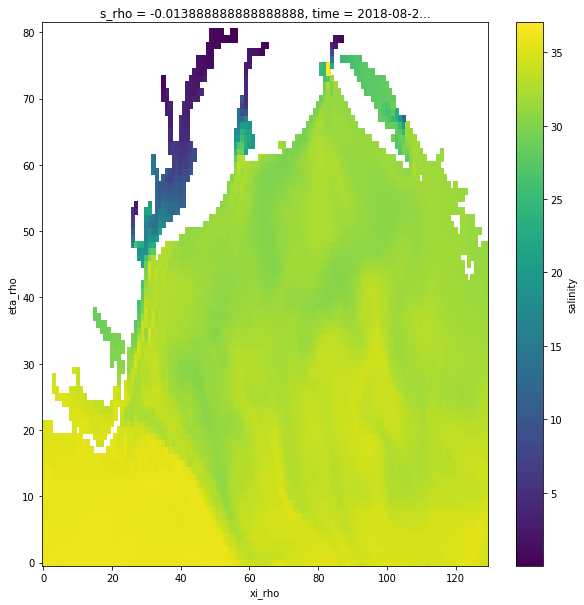

In [32]:
# There may be a no-data flag that's not properly set. The color map is not optimal, for that reason
# If I only knew more about ROMS model output!
x.plot(figsize=(10,10))

With cartopy, knowledge about the model structure, and a bit more work, we can create a nicer, more useful plot.

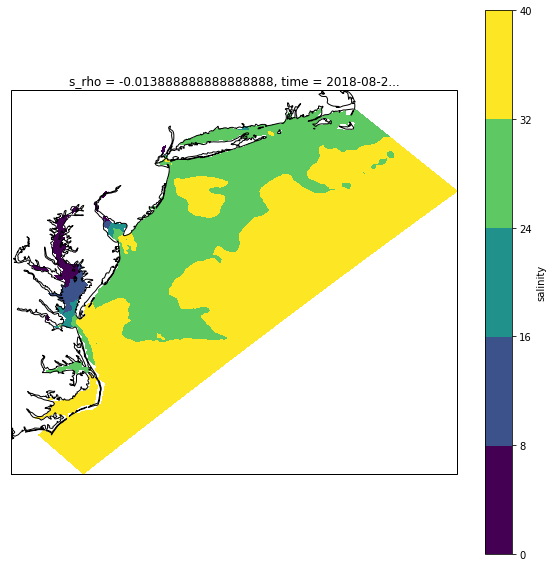

In [33]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)

x.plot.contourf(x='lon_rho', y='lat_rho',
    ax=ax,
    transform=ccrs.PlateCarree()
)
ax.coastlines('10m');